<a href="https://colab.research.google.com/github/nhaidaar/PCVK_Ganjil_2024/blob/main/xWeek12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> Nama : Muhammad Naufal Haidar Setyawan

> NIM : 2241720097

> Kelas : TI-3F

In [1]:
path = '/content/drive/MyDrive/S5_PCVK/Assets/'

# Praktikum
Lakukan Face Detection untuk image object lain yang tersedia pada (/images/facedet).

In [2]:
# Import library yang dibutuhkan
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import PIL
import io
import html
import time
from base64 import b64decode, b64encode
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js

In [3]:
def detect_face(img_path, classifier = path + 'haarcascades/haarcascade_frontalface_alt.xml'):
  cascade_wajah = cv.CascadeClassifier(classifier)
  img = cv.imread(img_path)
  img_copy = img.copy()
  roi_wajah = cascade_wajah.detectMultiScale(img)
  for (x,y,w,h) in roi_wajah:
    cv.rectangle(img_copy, (x,y), (x+w, y+h), (0,255,0), 3)
  plt.figure(figsize=(10,10))
  plt.subplot(121)
  plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
  plt.axis("off")
  plt.subplot(122)
  plt.imshow(cv.cvtColor(img_copy, cv.COLOR_BGR2RGB))
  plt.axis("off")
  plt.show()

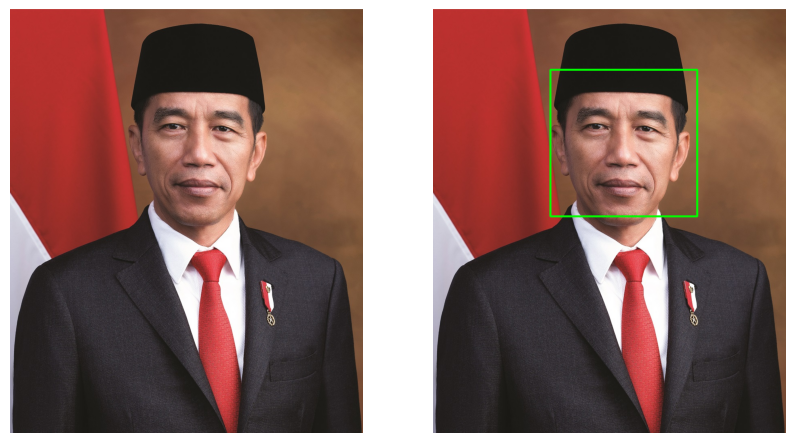

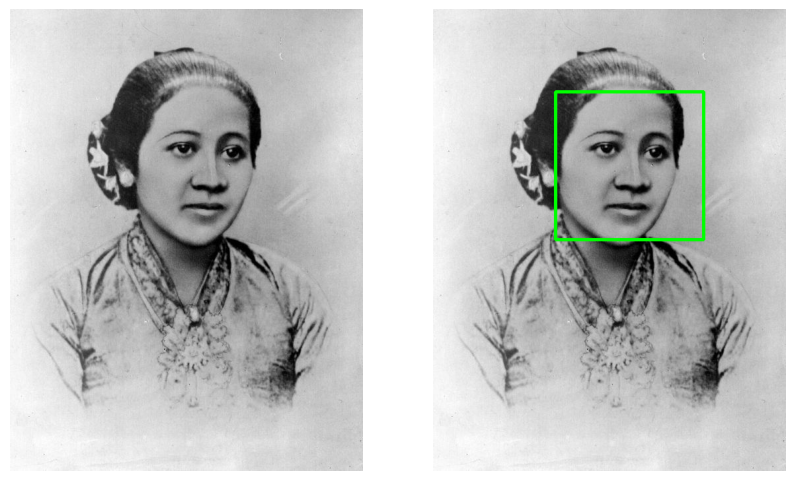

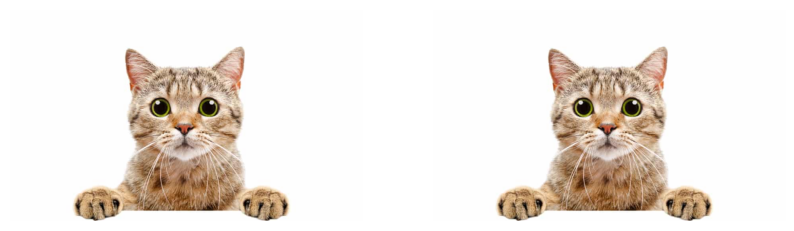

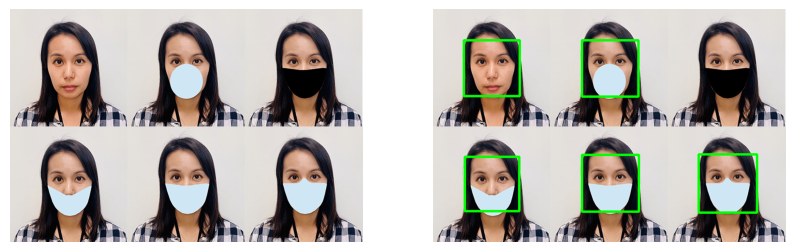

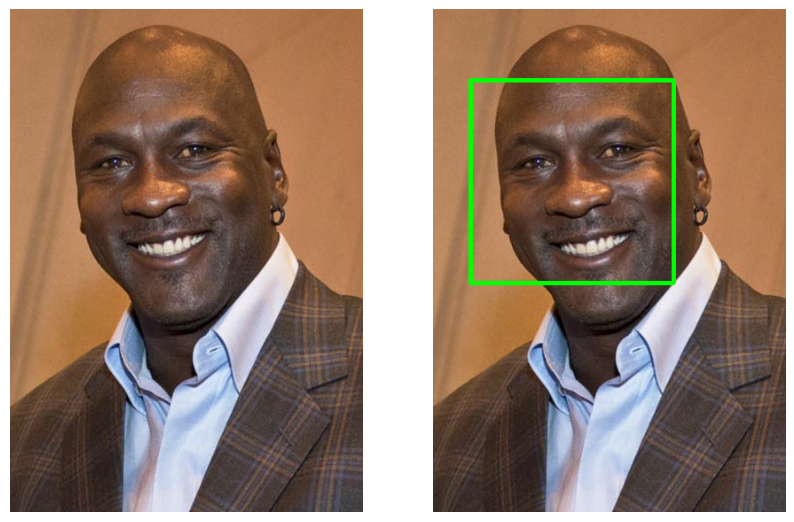

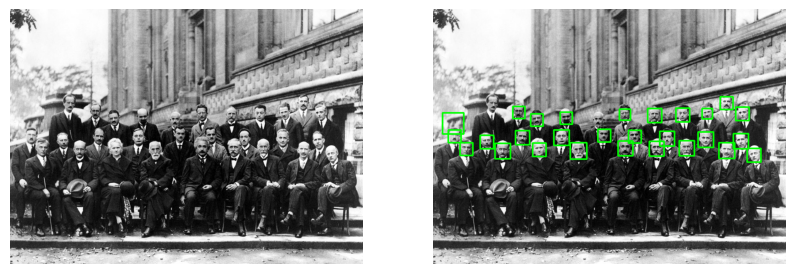

In [4]:
# Jokowi
detect_face(path + 'facedet/jokowi.jpg')
# Kartini
detect_face(path + 'facedet/kartini.jpg')
# Kucing
detect_face(path + 'facedet/kucing.jpg')
# Mask
detect_face(path + 'facedet/mask.png')
# Mjordan
detect_face(path + 'facedet/mjordan.jpg')
# Solvayconf
detect_face(path + 'facedet/solvayconf.jpg')

Pada Soal No.2. wajah kucing tidak bisa dideteksi dengan baik. Lakukan deteksi wajah kucing hingga muncul rectangle pada bagian wajahnya. Petunjuk pada soal ini, perhatikan pretrained features yang telah disediakan OpenCV. Gunakan xml yang ada jika memang telah disediakan. Jika belum ada, coba cari dengan searching melalui search engines.

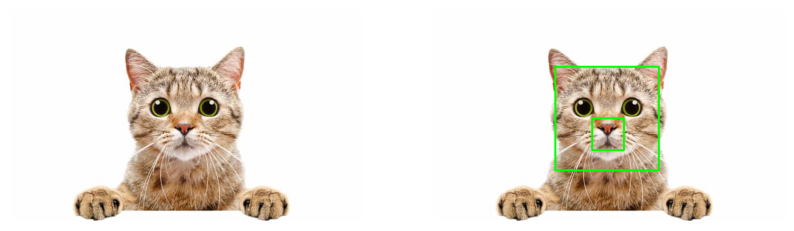

In [5]:
# Kucing
detect_face(path + 'facedet/kucing.jpg',path + 'haarcascades/haarcascade_frontalcatface.xml')

Cobakan juga untuk eyes detection.

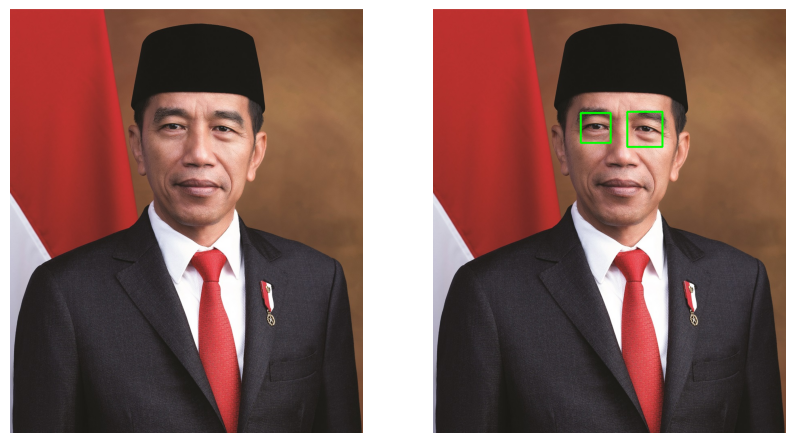

In [6]:
# Eyes Detection
detect_face(path + 'facedet/jokowi.jpg',path + 'haarcascades/haarcascade_eye.xml')

Lakukan Face Tracking menggunakan Google Colab.

In [7]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

# initialize the Haar Cascade face detection model
face_cascade = cv.CascadeClassifier(cv.samples.findFile(cv.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [8]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [10]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)
    # get face bounding box for overlay
    for (x,y,w,h) in faces:
      bbox_array = cv.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

Lakukan Blurring pada bagian wajah yang terdeteksi.

In [11]:
def blur_detect_face(img_path, classifier = path + 'haarcascades/haarcascade_frontalface_alt.xml'):
    cascade_wajah = cv.CascadeClassifier(classifier)
    img = cv.imread(img_path)
    img_copy = img.copy()
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    roi_wajah = cascade_wajah.detectMultiScale(gray)

    for (x, y, w, h) in roi_wajah:
        face_roi = img_copy[y:y+h, x:x+w]
        blurred_face = cv.GaussianBlur(face_roi, (99, 99), 30)
        img_copy[y:y+h, x:x+w] = blurred_face

    plt.figure(figsize=(10,10))
    plt.subplot(121)
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.title('Original')
    plt.axis("off")

    plt.subplot(122)
    plt.imshow(cv.cvtColor(img_copy, cv.COLOR_BGR2RGB))
    plt.title('Faces Blurred')
    plt.axis("off")

    plt.show()


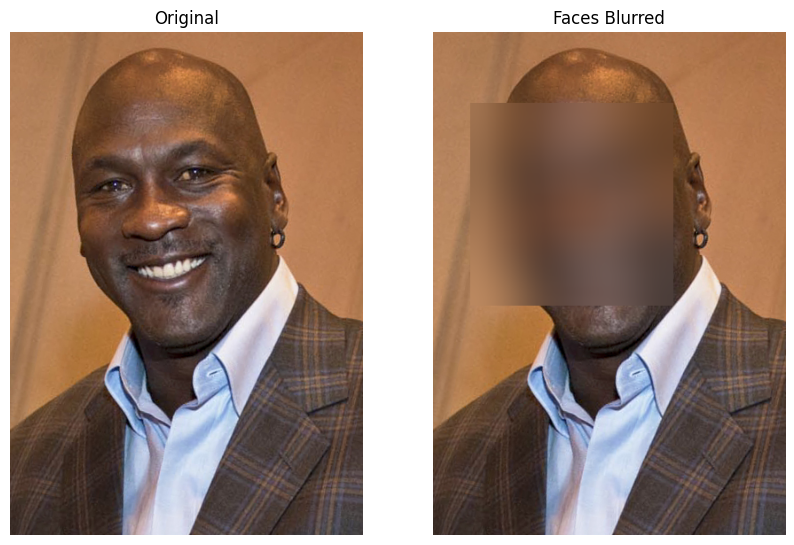

In [12]:
blur_detect_face(path + 'facedet/mjordan.jpg')

Lakukan segmentasi karakter pada KTP

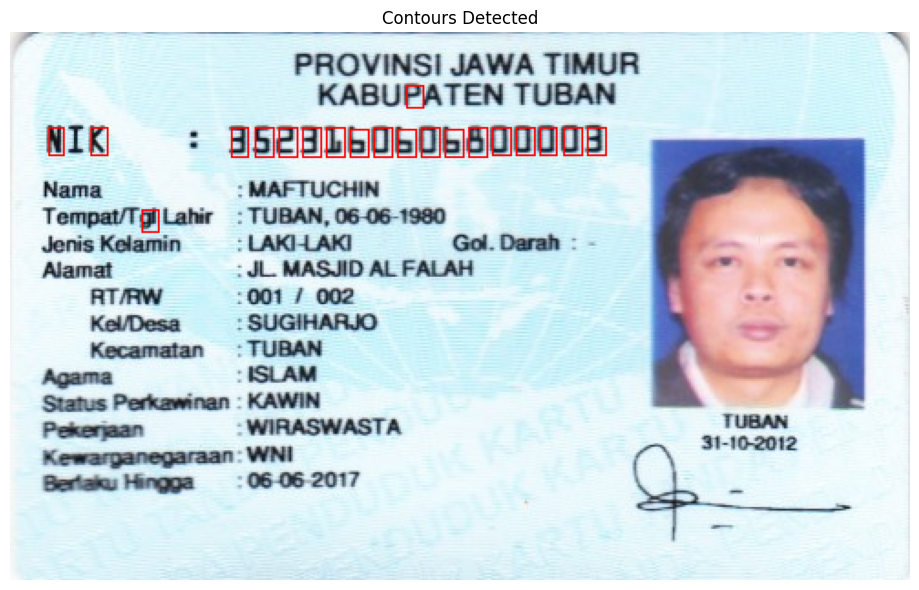

In [16]:
import cv2 as cv
import os

#  Siapkan file dataset, contoh pada praktik ini menggunakan Maftuchin Tuban
ktp = cv.imread(path + 'KTP_More/ktp3.png')

# Menerapkan Gaussian Blur
blurred = cv.GaussianBlur(ktp.copy(), (5, 5), 0.5)

# Ubah ke grayscale
gray = cv.cvtColor(blurred, cv.COLOR_BGR2GRAY)

ret, bw = cv.threshold(gray.copy(), 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

_, binary_image = cv.threshold(bw, 128, 255, cv.THRESH_BINARY_INV)
# Kernel untuk operasi morfologi
kernel = np.ones((2, 2), np.uint8)
# Operasi morfologi: Opening untuk memisahkan karakter
morph_image = cv.morphologyEx(binary_image, cv.MORPH_CLOSE, kernel, iterations=1)
# Temukan kontur
contours, _ = cv.findContours(morph_image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Tentukan batasan ukuran dan rasio untuk karakter NIK
min_area = 55
max_area = 130
aspect_ratio_range = (0.01, 0.9)

# Gambar asli untuk visualisasi kontur
output_image = ktp.copy()

for contour in contours:
    # Dapatkan bounding box dari setiap kontur
    x, y, w, h = cv.boundingRect(contour)

    # Hitung area dan rasio aspek dari bounding box
    area = cv.contourArea(contour)
    aspect_ratio = float(w) / h

    # Filter kontur berdasarkan ukuran dan rasio aspek
    if min_area <= area <= max_area and aspect_ratio_range[0] <= aspect_ratio <= aspect_ratio_range[1]:
        # Gambar bounding box pada karakter yang terdeteksi
        cv.rectangle(output_image, (x, y), (x + w, y + h), (0, 0, 255), 1)

# Visualisasi hasil
plt.figure(figsize=(10, 6))

plt.imshow(cv.cvtColor(output_image,cv.COLOR_BGR2RGB))
plt.title("Contours Detected")
plt.axis("off")

plt.tight_layout()
plt.show()

Lakukan cropping pada bagian NIK saja sehingga muncul hasil sebagai berikut

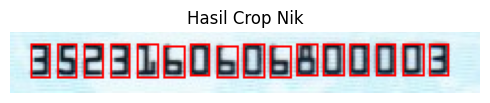

In [17]:
import cv2 as cv
import os

#  Siapkan file dataset, contoh pada praktik ini menggunakan Maftuchin Tuban
ktp = cv.imread(path + 'KTP_More/ktp3.png')

# Area NIK
x = 110
y = 45
w = 230
h = 30

ktp = ktp[y:y+h,x:x+w]

# Menerapkan Gaussian Blur
blurred = cv.GaussianBlur(ktp.copy(), (5, 5), 0.5)

# Ubah ke grayscale
gray = cv.cvtColor(blurred, cv.COLOR_BGR2GRAY)

ret, bw = cv.threshold(gray.copy(), 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

_, binary_image = cv.threshold(bw, 80, 255, cv.THRESH_BINARY_INV)

# Kernel untuk operasi morfologi
kernel = np.ones((3, 3), np.uint8)
# Operasi morfologi: Opening untuk memisahkan karakter
morph_image = cv.morphologyEx(binary_image, cv.MORPH_CLOSE, kernel, iterations=1)
# Temukan kontur
contours, _ = cv.findContours(morph_image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Tentukan batasan ukuran dan rasio untuk karakter NIK
min_area = 40
max_area = 170
aspect_ratio_range = (0.4, 1)

# Gambar asli untuk visualisasi kontur
output_image = ktp.copy()

for contour in contours:
    # Dapatkan bounding box dari setiap kontur
    x, y, w, h = cv.boundingRect(contour)

    # Hitung area dan rasio aspek dari bounding box
    area = cv.contourArea(contour)
    aspect_ratio = float(w) / h
    # Filter kontur berdasarkan ukuran dan rasio aspek
    if min_area <= area <= max_area and aspect_ratio_range[0] <= aspect_ratio <= aspect_ratio_range[1]:
        # Gambar bounding box pada karakter yang terdeteksi
        cv.rectangle(output_image, (x, y), (x + w, y + h), (0, 0, 255), 1)


# Visualisasi hasil
plt.figure(figsize=(5, 6))

plt.imshow(cv.cvtColor(output_image,cv.COLOR_BGR2RGB))
plt.title("Hasil Crop Nik")
plt.axis("off")

plt.tight_layout()
plt.show()

Kita akan menggunakan Deep Learning untuk melakukan pengenalan karakter Sebelum melakukan training data, terlebih dahulu di siapkan data yang akan dilakukan training yaitu data image nomor angka 0-9. Untuk membuat data tersebut bisa gunakan image editor untuk dilakukan croping satu persatu. Kemudian selanjutnya gunakan source code di bawah ini untuk proses persiapan untuk training.

In [18]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(28,28,1)),
  tf.keras.layers.ZeroPadding2D(padding=(2, 2)),
  tf.keras.layers.Conv2D(16, (5, 5), strides=(1, 1), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1),activation='relu'),
  tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1),activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), activation='relu'),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
model.fit(x_train, y_train, epochs=10)
model.evaluate(x_test, y_test)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 60s 31ms/step - accuracy: 0.8805 - loss: 0.3669
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 58s 31ms/step - accuracy: 0.9839 - loss: 0.0524
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - accuracy: 0.9887 - loss: 0.0361
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 84s 32ms/step - accuracy: 0.9909 - loss: 0.0293
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 80s 31ms/step - accuracy: 0.9921 - loss: 0.0247
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - accuracy: 0.9934 - loss: 0.0202
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 31ms/step - accuracy: 0.9949 - loss: 0.0163
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 80s 29ms/step - accuracy: 0.9950 - loss: 0.0153
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 30ms/step - accuracy: 0.9950 - loss: 0.0144
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 83s 30ms/step - accuracy: 0.9958 - loss: 0.0130
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9910 - loss: 0.0428


[0.03537750989198685, 0.9923999905586243]

In [20]:
model.save('model.keras')

# Tugas

Silakan melakukan pengenalan NIK pada e-KTP yang terdapat pada tugas modul 11!

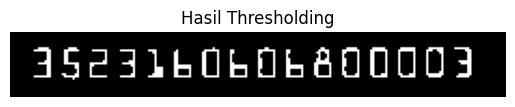

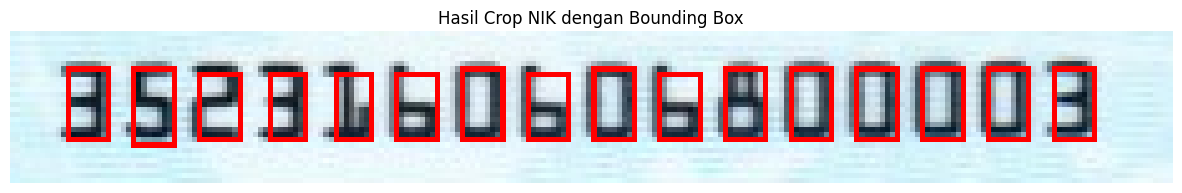

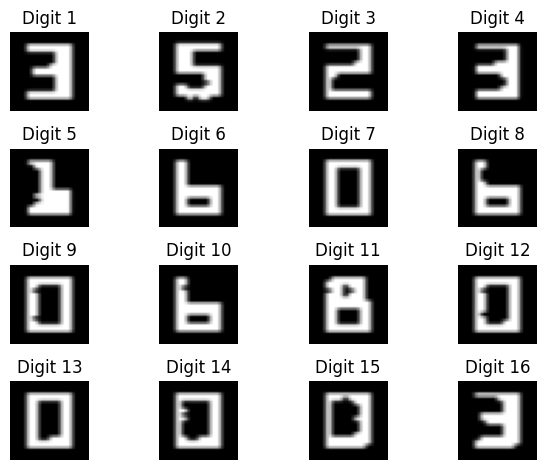

Jumlah digit yang terdeteksi: 16


In [21]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Siapkan file dataset
ktp = cv.imread(path + 'KTP_More/ktp3.png')

# Area NIK
x = 110
y = 45
w = 230
h = 30

ktp = ktp[y:y+h, x:x+w]

# Menerapkan Gaussian Blur
blurred = cv.GaussianBlur(ktp.copy(), (5, 5), 0.3)

# Ubah ke grayscale
gray = cv.cvtColor(blurred, cv.COLOR_BGR2GRAY)

ret, bw = cv.threshold(gray.copy(), 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

_, binary_image = cv.threshold(bw, 100, 255, cv.THRESH_BINARY_INV)

# Kernel untuk operasi morfologi
kernel = np.ones((2,2),np.uint8)
morph_image = cv.erode(binary_image,kernel,iterations = 1)
plt.imshow(morph_image, cmap='gray')
plt.title("Hasil Thresholding")
plt.axis("off")
plt.show()

# Temukan kontur
contours, _ = cv.findContours(morph_image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Tentukan batasan ukuran dan rasio untuk karakter NIK
min_area = 1
max_area = 100
aspect_ratio_range = (0.01, 1.4)

# Gambar asli untuk visualisasi kontur
output_image = ktp.copy()

# List untuk menyimpan digit-digit NIK
nik_digits = []

# Urutkan kontur dari kiri ke kanan
bounding_boxes = []
for contour in contours:
    x, y, w, h = cv.boundingRect(contour)
    area = cv.contourArea(contour)
    aspect_ratio = float(w) / h

    if min_area <= area <= max_area and aspect_ratio_range[0] <= aspect_ratio <= aspect_ratio_range[1]:
        bounding_boxes.append((x, y, w, h, contour))

# Urutkan berdasarkan koordinat x
bounding_boxes.sort(key=lambda x: x[0])

# Proses setiap digit
for box in bounding_boxes:
    x, y, w, h, contour = box

    # Crop digit
    digit_roi = binary_image[y:y+h, x:x+w]

    # Tambahkan padding (opsional)
    pad = 3
    digit_roi = cv.copyMakeBorder(digit_roi, pad, pad, pad, pad, cv.BORDER_CONSTANT, value=0)

    digit_roi = cv.resize(digit_roi, (28, 28))
    # Simpan digit ke list
    nik_digits.append(digit_roi)

    # Gambar rectangle untuk visualisasi
    cv.rectangle(output_image, (x, y), (x + w, y + h), (0, 0, 255), 1)

# Visualisasi hasil
plt.figure(figsize=(15, 6))

# Plot gambar asli dengan bounding box
plt.imshow(cv.cvtColor(output_image, cv.COLOR_BGR2RGB))
plt.title("Hasil Crop NIK dengan Bounding Box")
plt.axis("off")
plt.show()


# Plot digit-digit yang telah diekstrak
for i, digit in enumerate(nik_digits):
    plt.subplot(4, 4, i+1)
    plt.imshow(digit, cmap='gray')
    plt.title(f"Digit {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()
print(f"Jumlah digit yang terdeteksi: {len(nik_digits)}")

In [22]:
# Menggunakan model yang sudah ditrain untuk mendeteksi NIK
# Prediksi setiap digit
predictions = []
for digit in nik_digits:
    # Tambahkan dimensi batch
    digit_batch = np.expand_dims(digit, axis=0)
    # Prediksi
    pred = model.predict(digit_batch)
    # Ambil kelas dengan probabilitas tertinggi
    predicted_class = np.argmax(pred[0])
    predictions.append(predicted_class)

print("NIK terdeteksi:", "".join(map(str, predictions)))
print("NIK Asli      : 3523160606800003")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
NIK terdeteksi: 3523260606000003
NIK Asli      : 3523160606800003
